In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from aodfunctions.dependencies import *
from aodfunctions.general import *
from aodfunctions.settings import *
from aodfunctions.testbed import *
from aodfunctions.outofplane import *
# from aodfunctions.outofplane import *

cupyon=True

try: 
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    from numpy.lib.stride_tricks import as_strided
    print("cupy not installed. Using numpy.")

import diffractsim
diffractsim.set_backend("CPU") #Change the string to "CUDA" to use GPU acceleration

from diffractsim import MonochromaticField, Lens, nm, mm, cm, RectangularSlit


cupy not installed. Using numpy.
Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077
cupy not installed. Using numpy.


In [10]:
## Global Variables - REMEMBER TO UPDATE SETTINGS WHEN CHANGED
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 500
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 205*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = -20*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 20*10**(-6) # End location of the AOD in microns


optimizationbasisfunctions = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

num_particles = 10000
atommass = 1.41922*10**(-25) # Mass of the atom
tweezerdepth = 10**6 # Depth of the tweezer in Hertz
hbar = 6.626*10**(-34) / 2*cp.pi


globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [11]:
### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)

print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")
print(len(AWGwaveform))


numzframes = 20
zstart = focallength-5e-6
frame_zspacing = 1e-6
frame_size = cp.array([5e-6, 5e-6])
frameheight_real = 49

oop_variables = cp.array([numzframes, zstart, frame_zspacing, frame_size, frameheight_real])


Tweezer starting positions: -20.0 microns or -2.267573696145124 MHz
Tweezer ending positions: 20.0 microns or 2.267573696145124 MHz
One micron corresponds to 0.1133786848072586 MHz
9883


C:\Users\songo\AppData\Local\Temp\ipykernel_32016\3838716346.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  oop_variables = cp.array([numzframes, zstart, frame_zspacing, frame_size, frameheight_real])


In [12]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp_general(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)

expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)
expanded_acceleration, expanded_time = expand_position_array(time, optimized_acceleration, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
AWGinitguessexponential = exponentialphaseresponse(AWGinitguess)
# init_forces = retrieveforces(AWGinitguessexponential, globalvariables, 10, True)
# init_potentials = retrievepotentials(AWGinitguessexponential, globalvariables, 10, True)

fittedwaveform, fittedlegendre = init_opt_waveformfitLegendre(AWGinitguess, 1000, globalvariables)

Maximum error: 2.692328280318179e-07


In [5]:
movetimes = np.arange(100,154,2)*10**(-6)
movetemperatures = np.array([1])*10**(-6)

readout, movementframes = analyze_fixeddistance_nonoptimized_oop_2D(movetimes, movetemperatures, oop_variables, "Exponential", "Not Ideal", "SinSq", 30, globalvariables)

KeyboardInterrupt: 

In [13]:
movetimes = np.arange(150,200,5)*10**(-6)
movetemperatures = np.array([0.1])*10**(-6)

readout, movementframes = analyze_fixeddistance_nonoptimized_oop_2D(movetimes, movetemperatures, oop_variables, "Exponential", "Not Ideal", "SinSq", 30, globalvariables)

In [33]:
cp.shape(movementframes[0][0][0])

(12, 10000, 1)

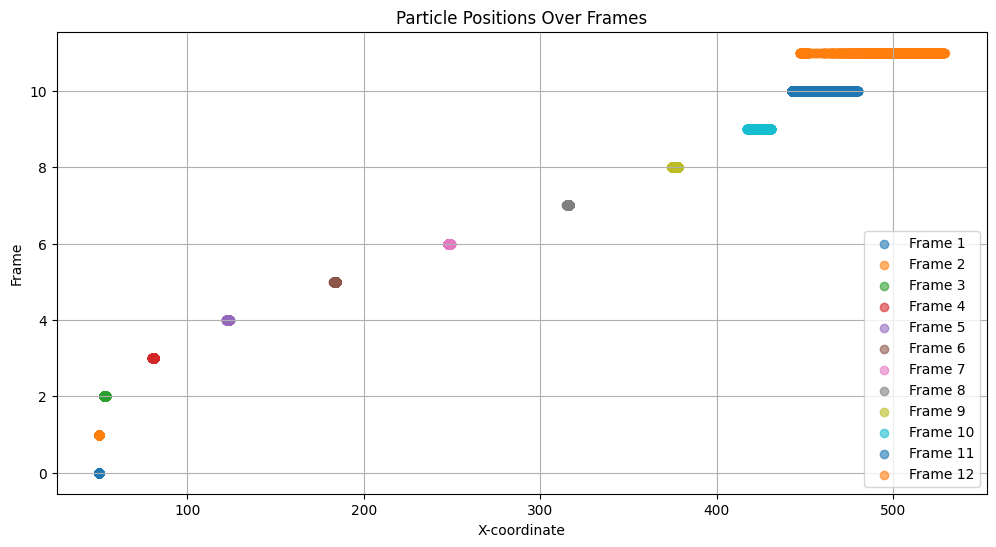

In [44]:

def plot_particle_positions(movementframes):
    # Convert CuPy array to NumPy array for plotting
    movementframes_np = movementframes
    N, M, C = cp.shape(movementframes_np)
    
    plt.figure(figsize=(12, 6))

    # Plot positions of particles in each frame
    for i in range(N):
        plt.scatter(movementframes_np[i], [i] * M, label=f'Frame {i+1}', alpha=0.6)

    # Adding labels and legend
    plt.xlabel('X-coordinate')
    plt.ylabel('Frame')
    plt.title('Particle Positions Over Frames')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_particle_positions(np.array(movementframes[1][0][0]))


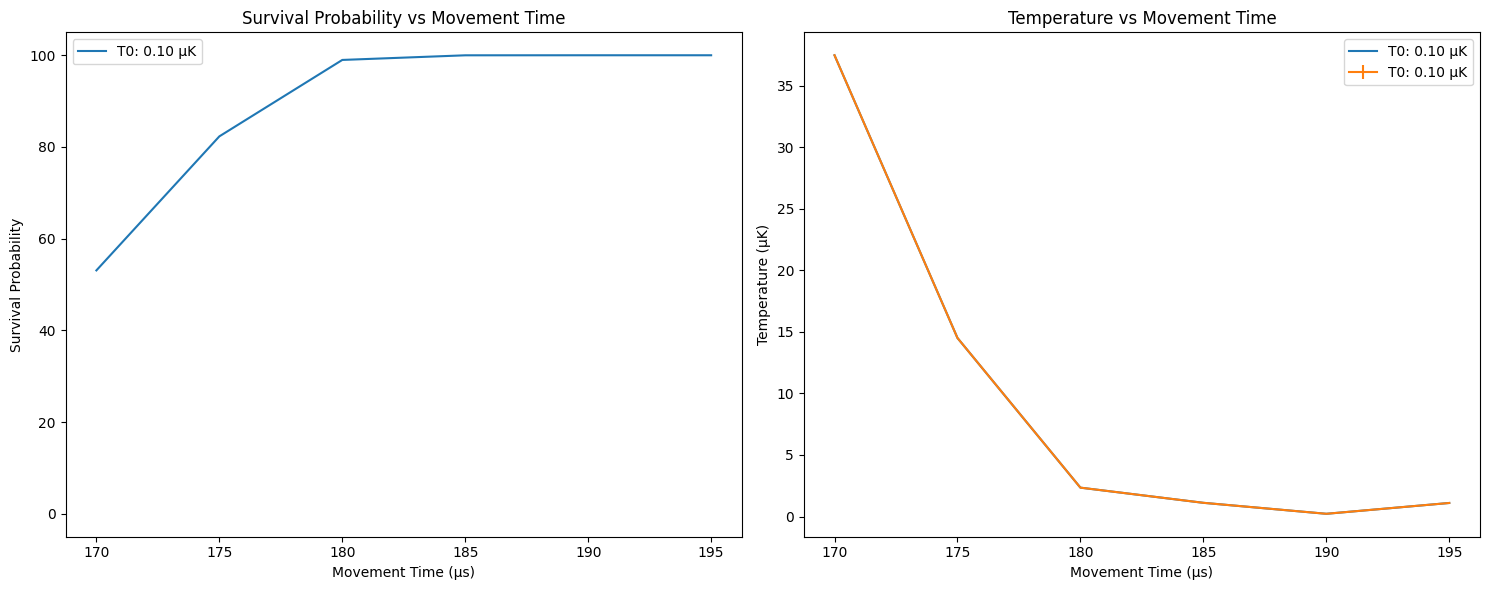

In [35]:
plots_fixeddistance(movetimes, movetemperatures, readout)

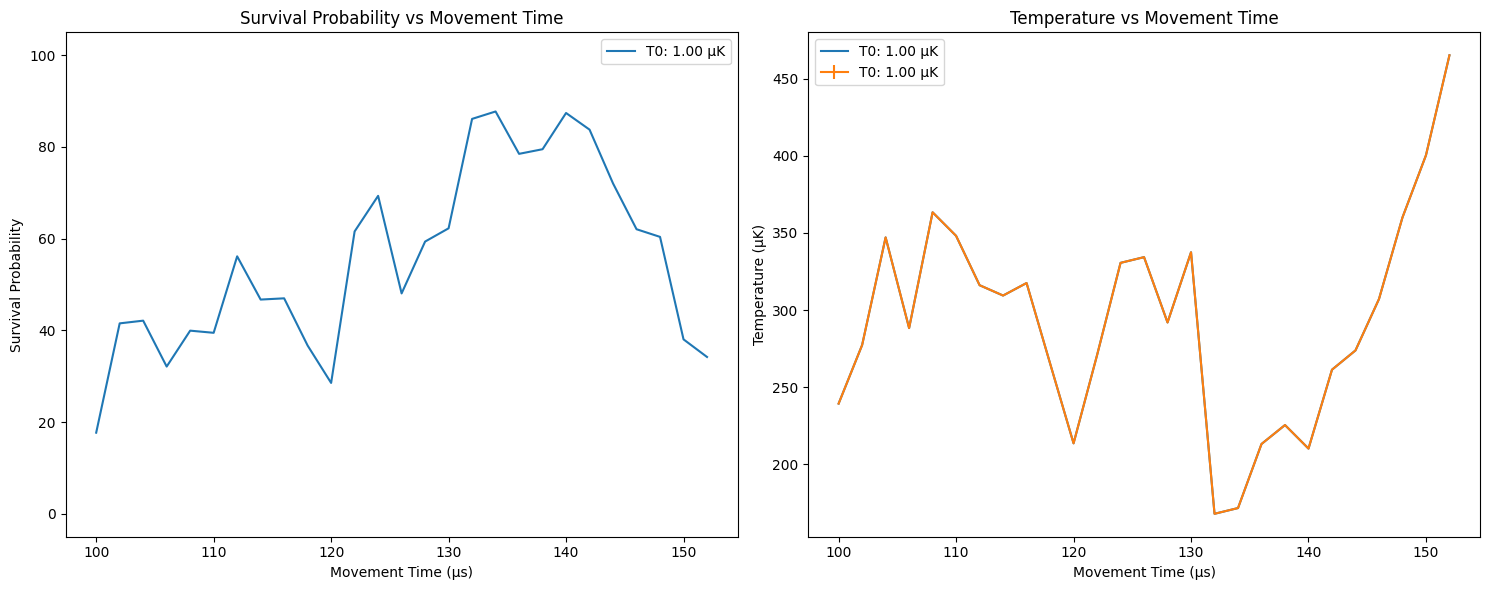

In [9]:
plots_fixeddistance(movetimes, movetemperatures, readout)

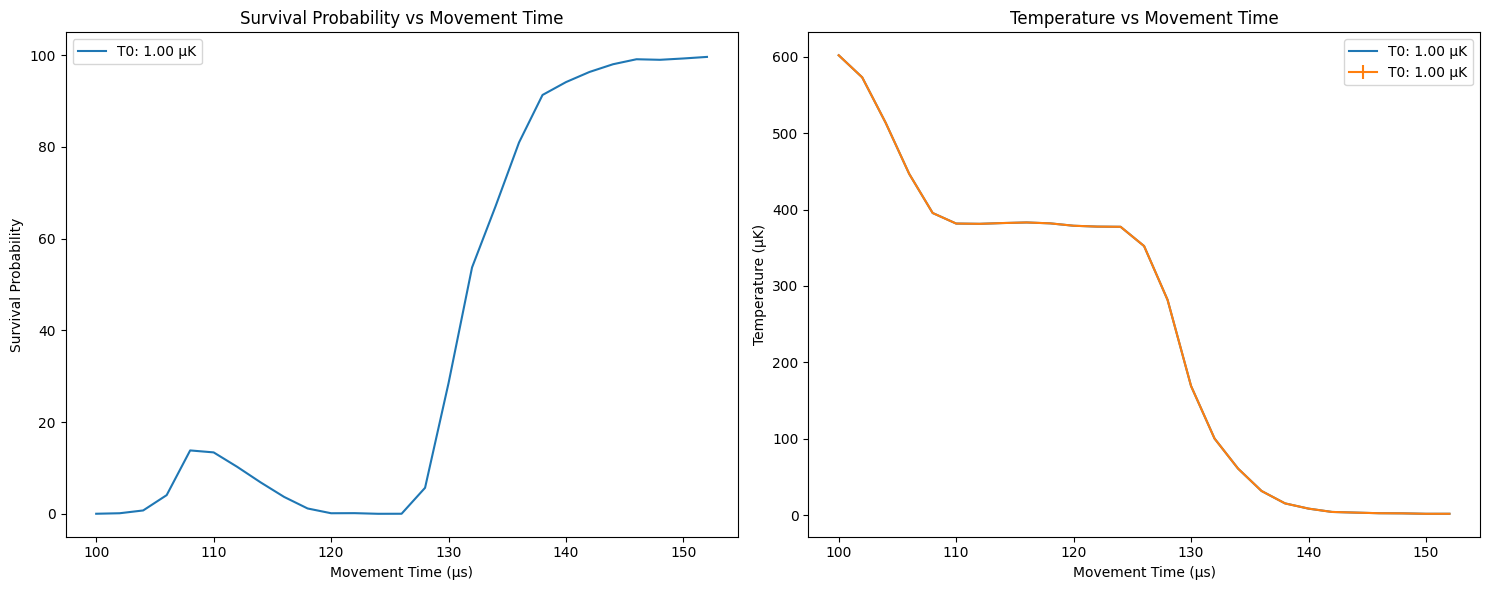

In [18]:
plots_fixeddistance(movetimes, movetemperatures, readout)

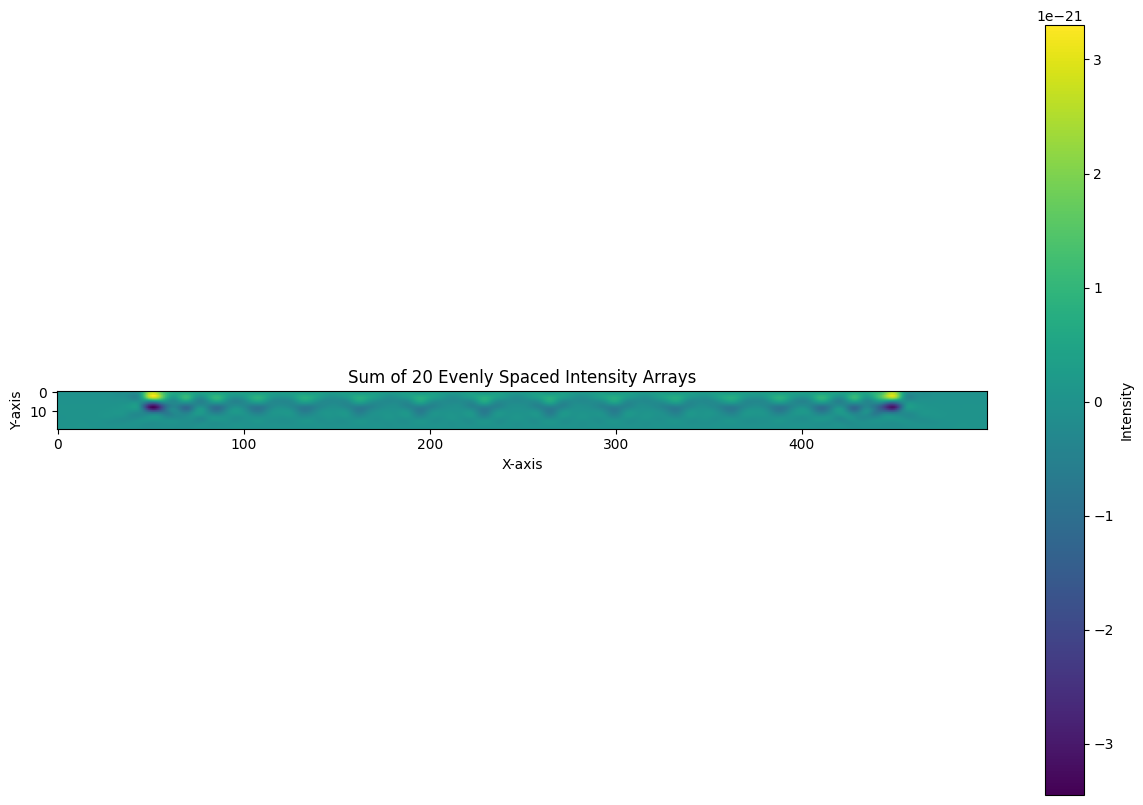

In [94]:
sum_and_plot_intensity_arrays(testout2[:,1], 20, fig_size=(15,10))

In [14]:
numzframes, zstart, frame_zspacing, frame_size, frameheight_real = oop_variables

frame_xspacing = (frame_size[0] * 2 + cp.abs(startlocation - endlocation)) / numpix_frame
# testout = retrieve_oop_potentials(AWGinitguessexponential, 20, focallength-5e-6, frame_zspacing,
#                                   49, frame_size, globalvariables, 10)

testout2 = retrieve_oop_forces(AWGinitguessexponential, numzframes, zstart, frame_zspacing, frameheight_real, frame_size, globalvariables, 100)

initdistribution = initdistribution_MaxwellBoltzmann3D(1000, 1e-8, 1e-8, zstart, frame_zspacing, frame_size, globalvariables)
p_out, dp_out, ddp_out = montecarlo_oop_2D(testout2, initdistribution, atommass, frame_size, frame_zspacing, globalvariables)

frame_xspacing = (frame_size[0] * 2 + cp.abs(startlocation - endlocation)) / numpix_frame # in units of meters / FRAME pixel
finalposition_x = (frame_size[0]  + cp.abs(startlocation - endlocation))  / frame_xspacing # In units of FRAME pixels
finalposition_z = (focallength - zstart) / frame_zspacing
finalposition = cp.array([finalposition_x, finalposition_z])

calibration_potential = snapshots_oop_potential(AWGinitguessexponential[-numpix_frame:], 1, numzframes, zstart, frame_zspacing, 
                                                frameheight_real, frame_size, globalvariables)
tweezerwidths = fit_gaussian_2d(calibration_potential)

percentagelive = analyze_survivalprobability_oop_2D(p_out, finalposition, tweezerwidths, globalvariables)